# Import libraries

In [1]:
import sys
sys.path.insert(0,'..')
from embedding_net.models import TripletNet
from embedding_net.utils import parse_params
from embedding_net.datagenerators import ENDataLoader, SimpleDataGenerator, SiameseDataGenerator, SimpleTripletsDataGenerator, TripletsDataGenerator
from embedding_net.utils import plot_tsne_interactive, plot_batch_simple, plot_batch
import albumentations as A
import matplotlib.pyplot as plt 
import numpy as np
import cv2
import time
import numpy as np

## Test Embedding Net Data Loaders

#### Load dataloader

In [4]:
dataset_path = '/home/rauf/datasets/plates/plates_splitted/'
input_shape=(48, 48, 3)
batch_size = 8

dataset_path = '/home/rauf/datasets/RTSD/'
train_csv_file = '/home/rauf/datasets/RTSD/split_1/train.csv'

data_loader = ENDataLoader( dataset_path,
                       train_csv_file=train_csv_file,
                       image_id_column = 'file_path',
                       label_column = 'class_name')
simple_data_generator = SimpleDataGenerator(class_files_paths=data_loader.train_data,
                                            class_names=data_loader.class_names,
                                            batch_size=batch_size,
                                            input_shape=input_shape)

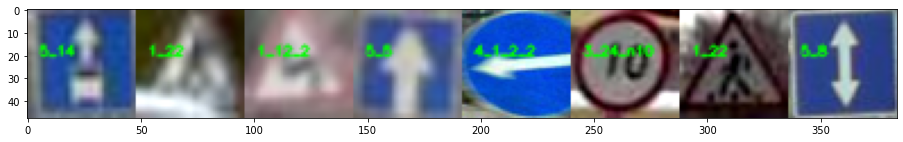

In [5]:
data, targets = simple_data_generator.__getitem__(1)
plot_batch_simple(data, targets, data_loader.class_names)

#### Test pairs dataloader

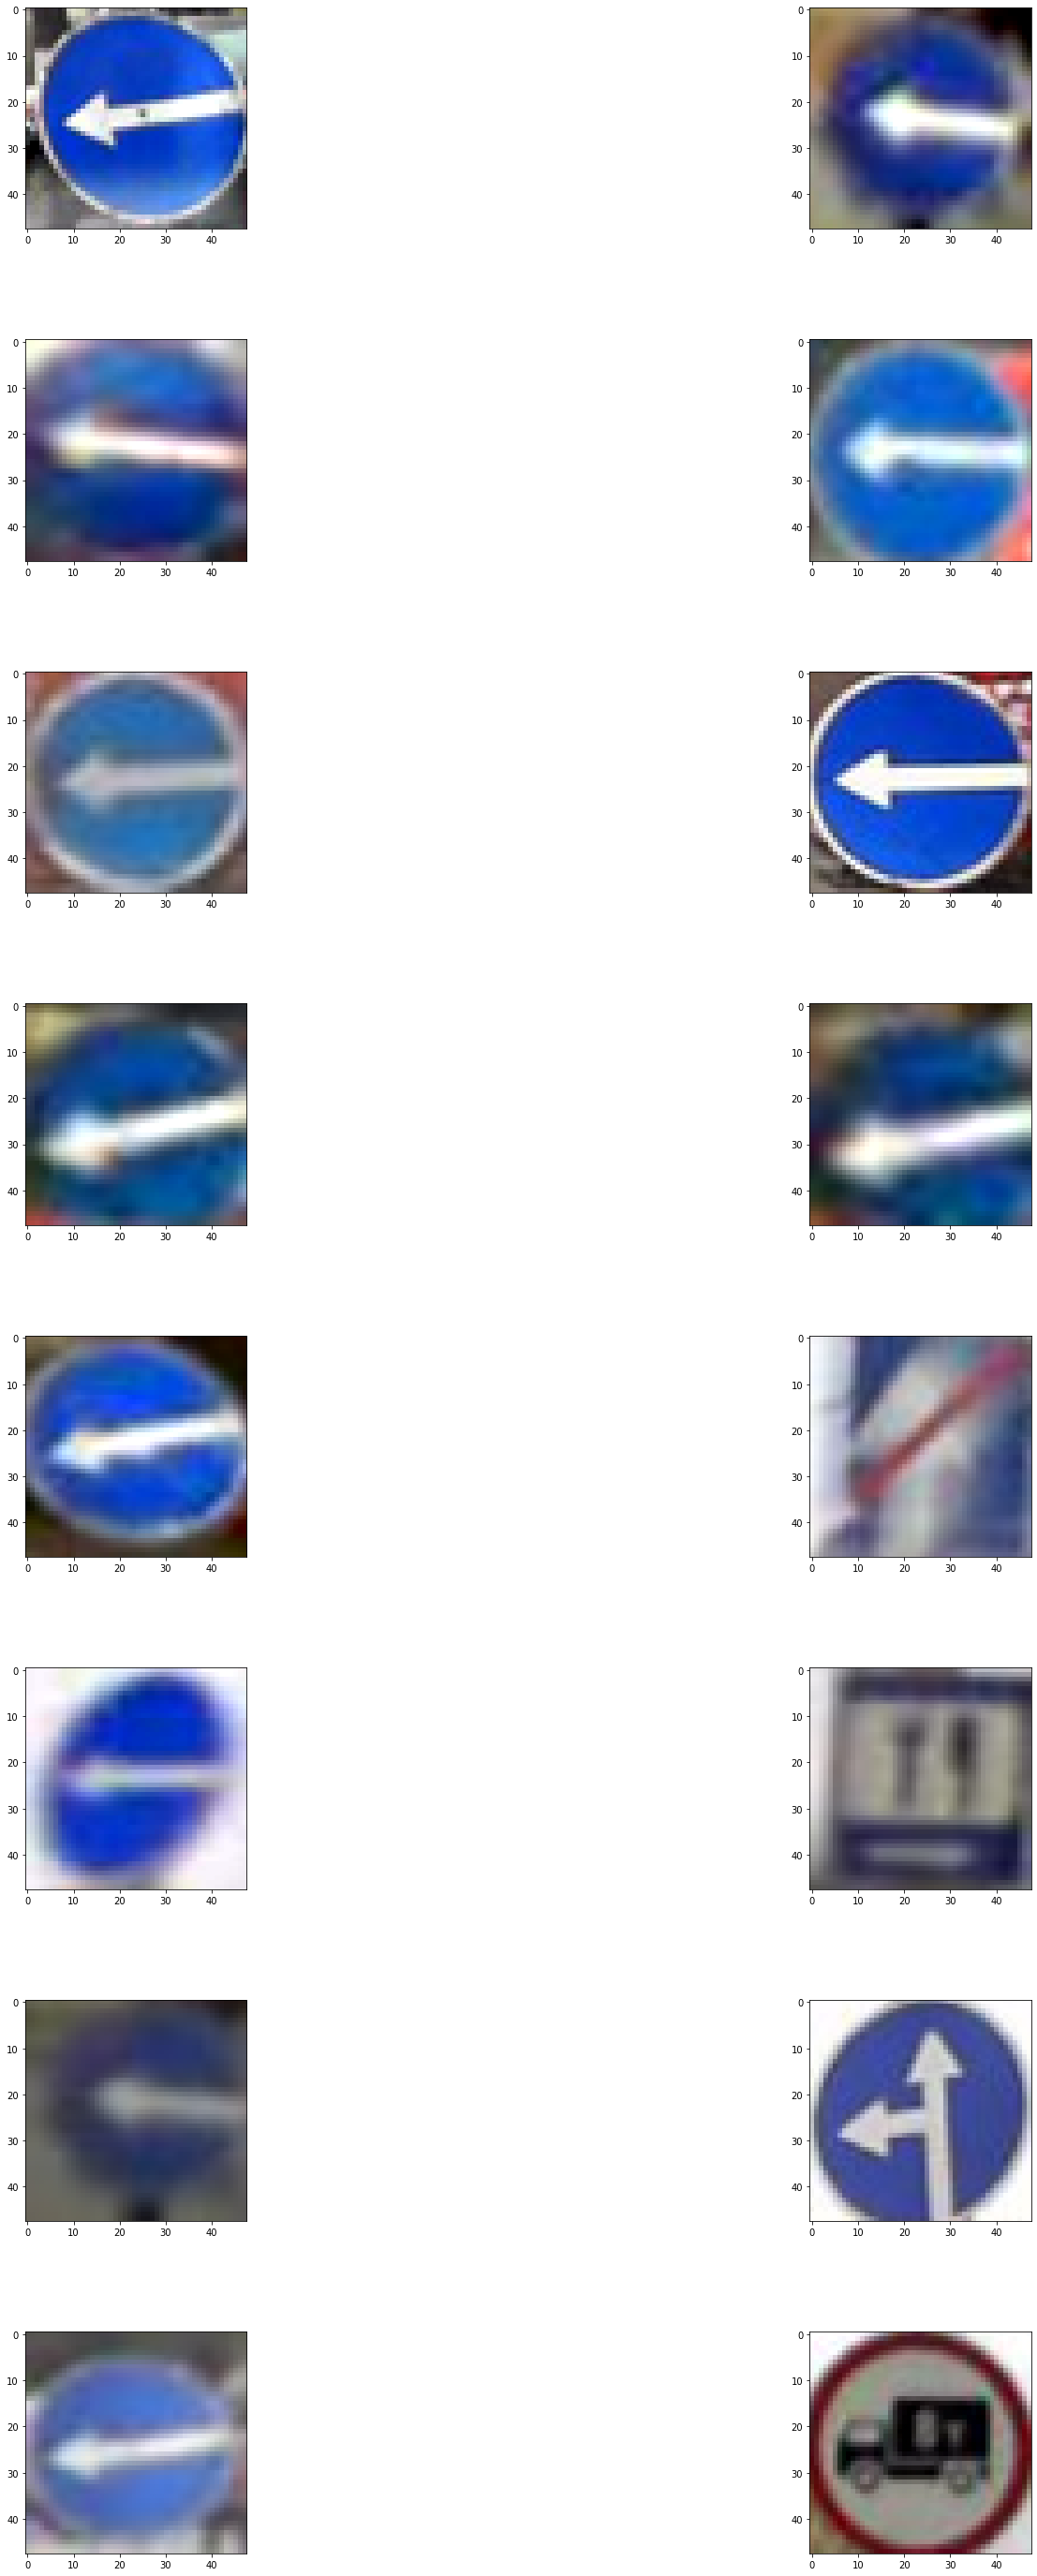

In [6]:
pairs_data_generator = SiameseDataGenerator(class_files_paths=data_loader.train_data,
                                            class_names=data_loader.class_names,
                                            batch_size=batch_size,
                                            input_shape=input_shape)
data, targets = pairs_data_generator.__getitem__(1)
plot_batch(data, targets)

#### Test triplets dataloader

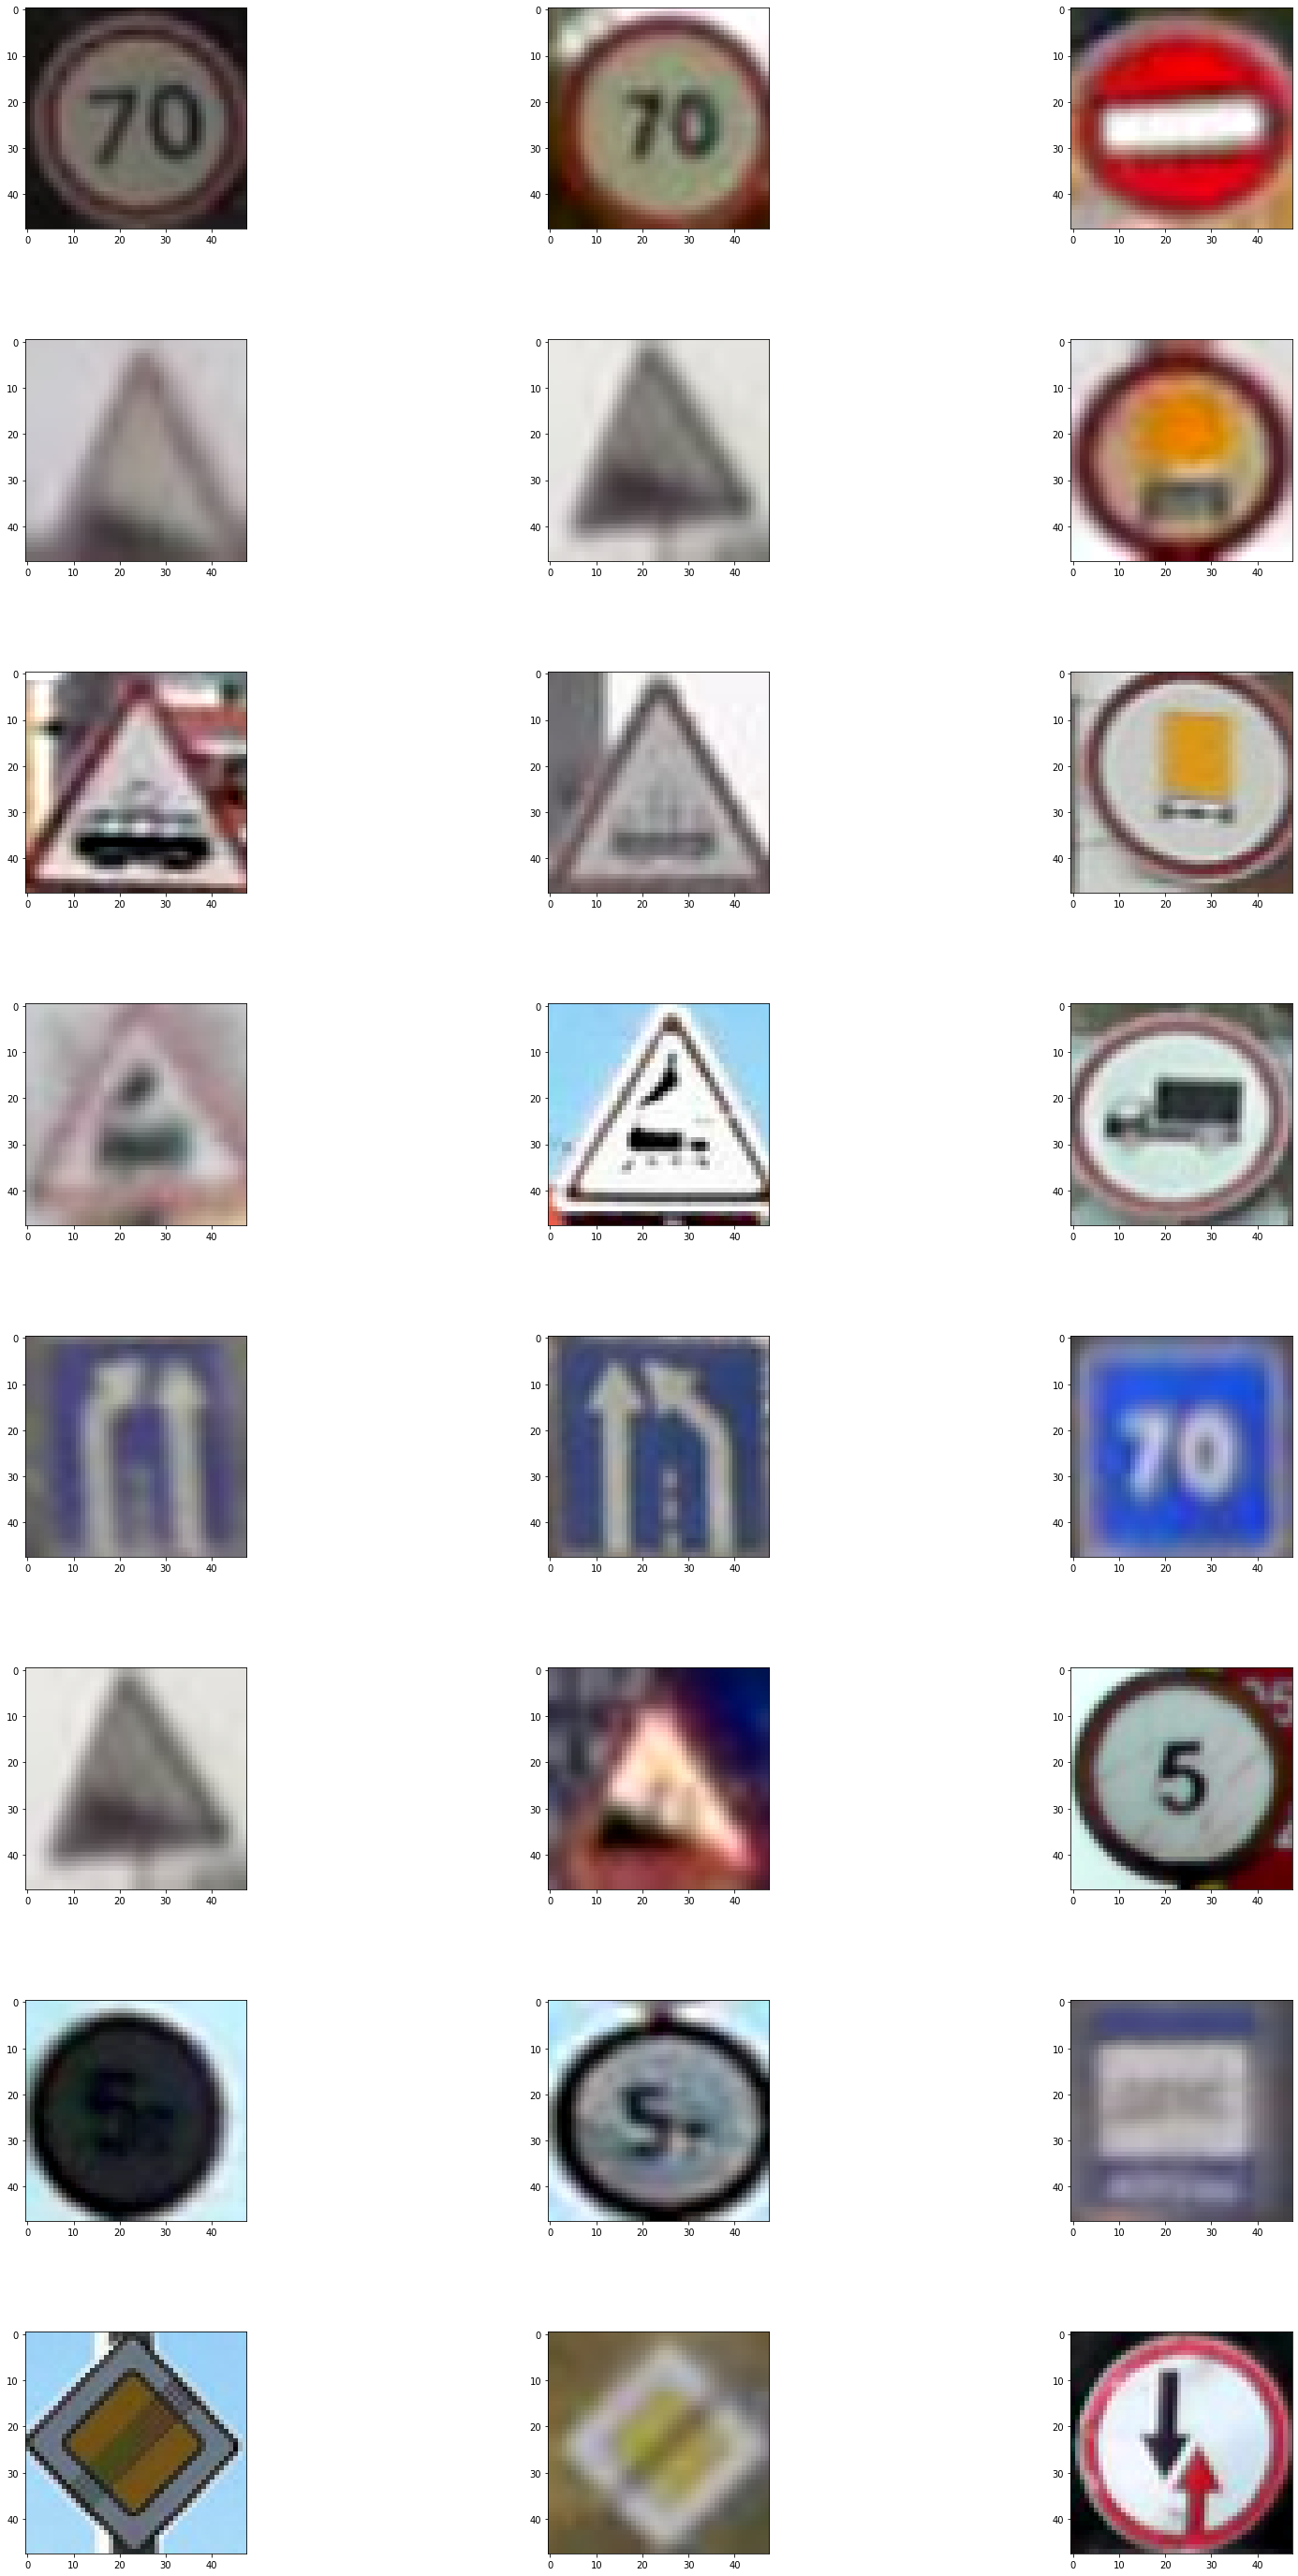

In [7]:
simple_triplets_data_generator = SimpleTripletsDataGenerator(class_files_paths=data_loader.train_data,
                                                      class_names=data_loader.class_names,
                                                      batch_size=batch_size,
                                                      input_shape=input_shape)
data, targets = simple_triplets_data_generator.__getitem__(1)
plot_batch(data, targets)

#### Test triplets dataloader with negative mining techniques

In [8]:
config_name = 'road_signs_apollo.yml'
cfg_params = parse_params(f'../configs/{config_name}')
model = TripletNet(cfg_params, training=True)
model.load_model('../work_dirs/road_signs_efnb0/weights/best_road_signs_efnb0_003_0.188333.hdf5')

Base model summary
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 24, 24, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 24, 24, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 24, 24, 32)   0           stem_bn[0][0]                    
_________________________________________________________________________

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f427c99d410>, <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f427c99d4d0>, <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f427c99d610>, <tensorflow.python.keras.engine.training.Model object at 0x7f427c99df50>, <tensorflow.python.keras.layers.merge.Concatenate object at 0x7f4266158fd0>]


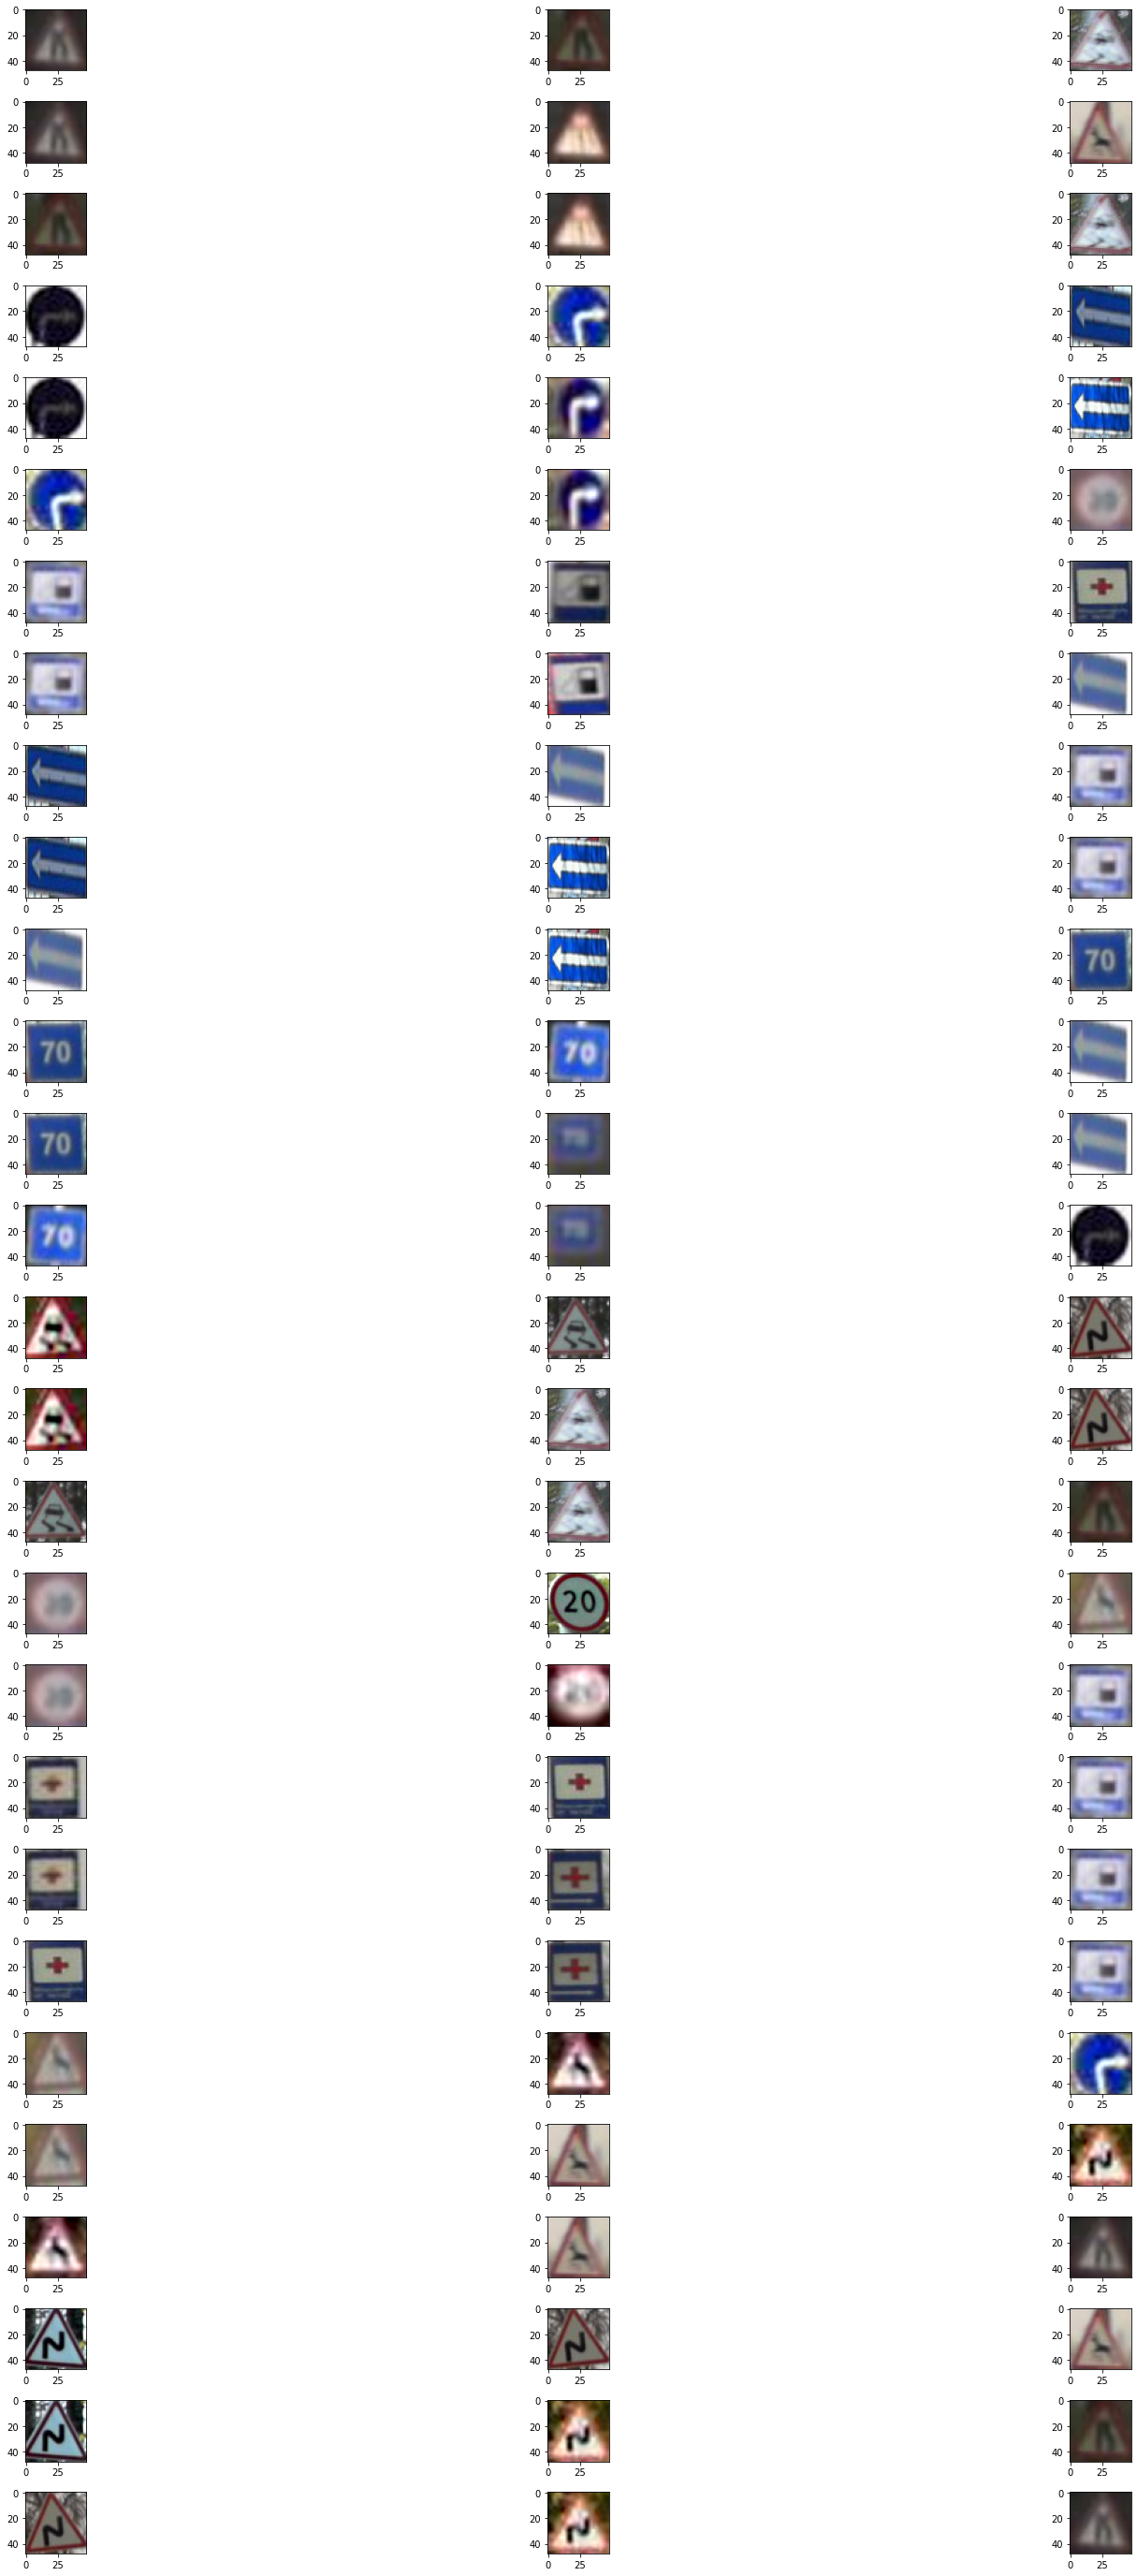

In [9]:
triplets_data_generator = TripletsDataGenerator(model.base_model,
                                                class_files_paths=data_loader.train_data,
                                                class_names=data_loader.class_names,
                                                batch_size=batch_size,
                                                input_shape=input_shape,
                                                k_classes=10,
                                                k_samples=3)
data, targets = triplets_data_generator.__getitem__(1)
plot_batch(data, targets)

## Test trained network

#### Load network

In [1]:
import sys
sys.path.insert(0,'..')
from embedding_net.models import TripletNet
from embedding_net.datagenerators import ENDataLoader
from embedding_net.utils import parse_params
from embedding_net.utils import plot_tsne_interactive

config_name = 'road_signs_apollo.yml'
cfg_params = parse_params(f'../configs/{config_name}')
model = TripletNet(cfg_params, training = False)
model.load_model('../work_dirs/road_signs_efnb1/weights/epoch_001.hdf5')
data_loader = ENDataLoader(**cfg_params['dataloader'])

encoded_training_data = model.generate_encodings(data_loader, max_n_samples=50, shuffle=False)
# model.save_encodings(encoded_training_data)
# plot_tsne_interactive(encoded_training_data)
# model.save_base_model('../work_dirs/road_signs_efnb0/weights/')
model.save_onnx('../work_dirs/road_signs_efnb1/weights/')
# model.load_encodings('encodings/road_signs/encodings_{}.pkl')

tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 906 -> 468


In [2]:
plot_tsne_interactive(encoded_training_data)

#### Train sklearn_model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
import pickle
import joblib

k_val = 3
classification_model = KNeighborsClassifier(n_neighbors=k_val)
with open('encodings.pkl', 'rb') as f:
    data = pickle.load(f)
classification_model.fit(data['encodings'], data['labels'])
joblib.dump(classification_model,'classif_model.sav')

In [ ]:
import cv2
dataset_path = '/home/rauf/datasets/bengali/pngs/test/'
for i in range(12):
    img = cv2.imread(dataset_path+'Test_{}.png'.format(i))
    encoding = model.base_model.predict(np.expand_dims(img, axis=0))
    predicted_label = classification_model.predict(encoding)
    print(predicted_label)

#### Test model on a single image

In [ ]:
img_path = '/home/rauf/datasets/plates/plates/test/0327.jpg'

img = cv2.imread(img_path)
img = cv2.resize(img,tuple(cfg_params['input_shape'][:2]))
encoding = model.base_model.predict(np.expand_dims(img, axis=0))

tm = 0
for i in range(100):
    start = time.time()
    prediction = model.predict_knn(img_path)[0]
    end = time.time()
    tm += (end - start)
average_time = tm/100
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imgplot = plt.imshow(img)
plt.show()

print(prediction)
print(average_time)

#### Calculate model accuracy on validation set

In [ ]:
model_accuracies = model.calculate_prediction_accuracy()
print('Model top1 accuracy on validation set: {}'.format(model_accuracies['top1']))
print('Model top5 accuracy on validation set: {}'.format(model_accuracies['top5']))

#### Plot t-SNE

In [ ]:
path_to_encodings = 'work_dirs/{}/encodings/encodings_{}.pkl'.format(config_name, config_name)
plot_tsne_interactive(encodings_path=path_to_encodings)

## t-SNE without training

In [ ]:
config_name = 'paper_resnet18_with_softmax'
cfg_params = parse_net_params('configs/{}.yml'.format(config_name))
model = EmbeddingNet(cfg_params, training = False)

model.generate_encodings(save_file_name='work_dirs/{}/encodings/encodings_without_training_{}.pkl'.format(config_name, config_name),
                         max_num_samples_of_each_class=30, knn_k = 1, shuffle=True)

In [ ]:
path_to_encodings = 'work_dirs/{}/encodings/encodings_without_training_{}.pkl'.format(config_name, config_name)
plot_tsne_interactive(encodings_path=path_to_encodings)

#### Calculate model accuracy on validation set

In [ ]:
model_accuracies = model.calculate_prediction_accuracy()
print('Model top1 accuracy on validation set: {}'.format(model_accuracies['top1']))
print('Model top5 accuracy on validation set: {}'.format(model_accuracies['top5']))

## Test simple classification network

In [ ]:
dataset_path = '/home/rauf/datasets/road_signs/road_signs_separated/'
input_shape=(48, 48, 3)
config_name = 'paper_resnet18_softmax_only'

data_loader = EmbeddingNetImageLoader(dataset_path, input_shape=input_shape, min_n_obj_per_class = 30, 
                                        select_max_n_obj_per_class = 30,
                                        max_n_obj_per_class = 10000)
model = load_model('work_dirs/{}/weights/pretraining_model/best_model_{}.h5'.format(config_name, config_name))

In [ ]:
img_path = '/home/rauf/datasets/road_signs/road_signs_separated/train/4_1_3/rtsd-r1_test_005272.png'
img = cv2.imread(img_path)

tm = 0
for i in range(100):
    start = time.time()
    prediction_vector = model.predict(np.expand_dims(img, axis=0))
    prediction = data_loader.classes['val'][np.argmax(prediction_vector[0])]
    end = time.time()
    tm += (end - start)
average_time = tm/100
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imgplot = plt.imshow(img)
plt.show()

print(prediction)
print(average_time)

In [ ]:
print(len(data_loader.classes['val']))
print(data_loader.classes['val'])
correct = 0
total_n_of_images = len(data_loader.images_paths['val'])
for img_path, img_label in zip(data_loader.images_paths['val'],
                               data_loader.images_labels['val']):
    
    img = data_loader.get_image(img_path)
    prediction_vector = model.predict(np.expand_dims(img, axis=0))
    prediction = data_loader.classes['val'][np.argmax(prediction_vector[0])]

    if prediction == img_label:
        correct+=1
print(correct/total_n_of_images)

#### Generate submission file

In [ ]:
import pandas as pd
import albumentations as A
import os

d = {'id':[],
     'label':[]}

input_shape=(128, 128, 3)
augmentations = A.Compose([
    A.CenterCrop(p=1, height=2*input_shape[1]//3, width=2*input_shape[0]//3),
    A.Resize(p=1, height=input_shape[1], width=input_shape[0])
], p=1)

for i in range(744):
    f = '0' * (4-len(str(i))) + str(i) + '.jpg'
    if f.endswith('.jpg') or f.endswith('.png'):
        img_path = '/home/rauf/datasets/plates/plates/test/{}'.format(f)
        img = cv2.imread(img_path)
        img = augmentations(image=img)['image']
        prediction = model.predict_knn(img)
        id_num = int(f.split('.')[0])
        d['id'].append(id_num)
        d['label'].append(prediction[0])

        print(f)
        print(prediction[0])
#         img = cv2.imread(img_path)
#         imgplot = plt.imshow(img)
#         plt.show()

if os.path.exists('sub3.csv'):
    os.remove('sub3.csv')
else:
    print("The file does not exist")
df = pd.DataFrame(data=d)
df.to_csv('sub3.csv', index=False)